In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time

import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

### Configurations
data_dir = '/opt/ml/input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'

In [3]:
df = pd.read_csv(df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [4]:
def get_ext(img_dir, img_id):
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [5]:
def get_img_stats(img_dir, img_ids):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [6]:
img_info = get_img_stats(img_dir, df.path.values)

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')


RGB Mean: [0.56019358 0.52410121 0.501457  ]
RGB Standard Deviation: [0.23318603 0.24300033 0.24567522]


In [7]:
mean, std = (0.5, 0.5, 0.5), (0.2, 0.2, 0.2)

In [8]:
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur, RandomRotation, ColorJitter


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


def get_transforms(need=('train', 'val'), img_size=(512, 384)):
    transformations = {}
    if 'train' in need:
        transformations['train'] = transforms.Compose([
            Resize((img_size[0], img_size[1])),
            RandomRotation([-8, +8]),
            GaussianBlur(51, (0.1, 2.0)),
            ColorJitter(brightness=0.5, saturation=0.5, hue=0.5),  # todo : param
            ToTensor(),
            Normalize(mean=mean, std=std),
            AddGaussianNoise(0., 1.)
        ])
    if 'val' in need:
        transformations['val'] = transforms.Compose([
            Resize((img_size[0], img_size[1])),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])
    return transformations

In [9]:
from albumentations import *
from albumentations.pytorch import ToTensorV2


def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

In [10]:
## 마스크 여부, 성별, 나이를 mapping할 클래스를 생성합니다.

class MaskLabels:
    mask = 0
    incorrect = 1
    normal = 2

class GenderLabels:
    male = 0
    female = 1

class AgeGroup:
    map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 60 else 2

In [11]:
class MaskBaseDataset(data.Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1.jpg": MaskLabels.mask,
        "mask2.jpg": MaskLabels.mask,
        "mask3.jpg": MaskLabels.mask,
        "mask4.jpg": MaskLabels.mask,
        "mask5.jpg": MaskLabels.mask,
        "incorrect_mask.jpg": MaskLabels.incorrect,
        "normal.jpg": MaskLabels.normal
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            for file_name, label in self._file_names.items():
                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.mask_labels.append(label)

                    id, gender, race, age = profile.split("_")
                    gender_label = getattr(GenderLabels, gender)
                    age_label = AgeGroup.map_label(age)

                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

In [12]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.
transform = get_transforms(mean=mean, std=std)

dataset = MaskBaseDataset(
    img_dir=img_dir
)

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

In [13]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=False
)

In [14]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([12, 3, 512, 384])
labels shape: torch.Size([12])


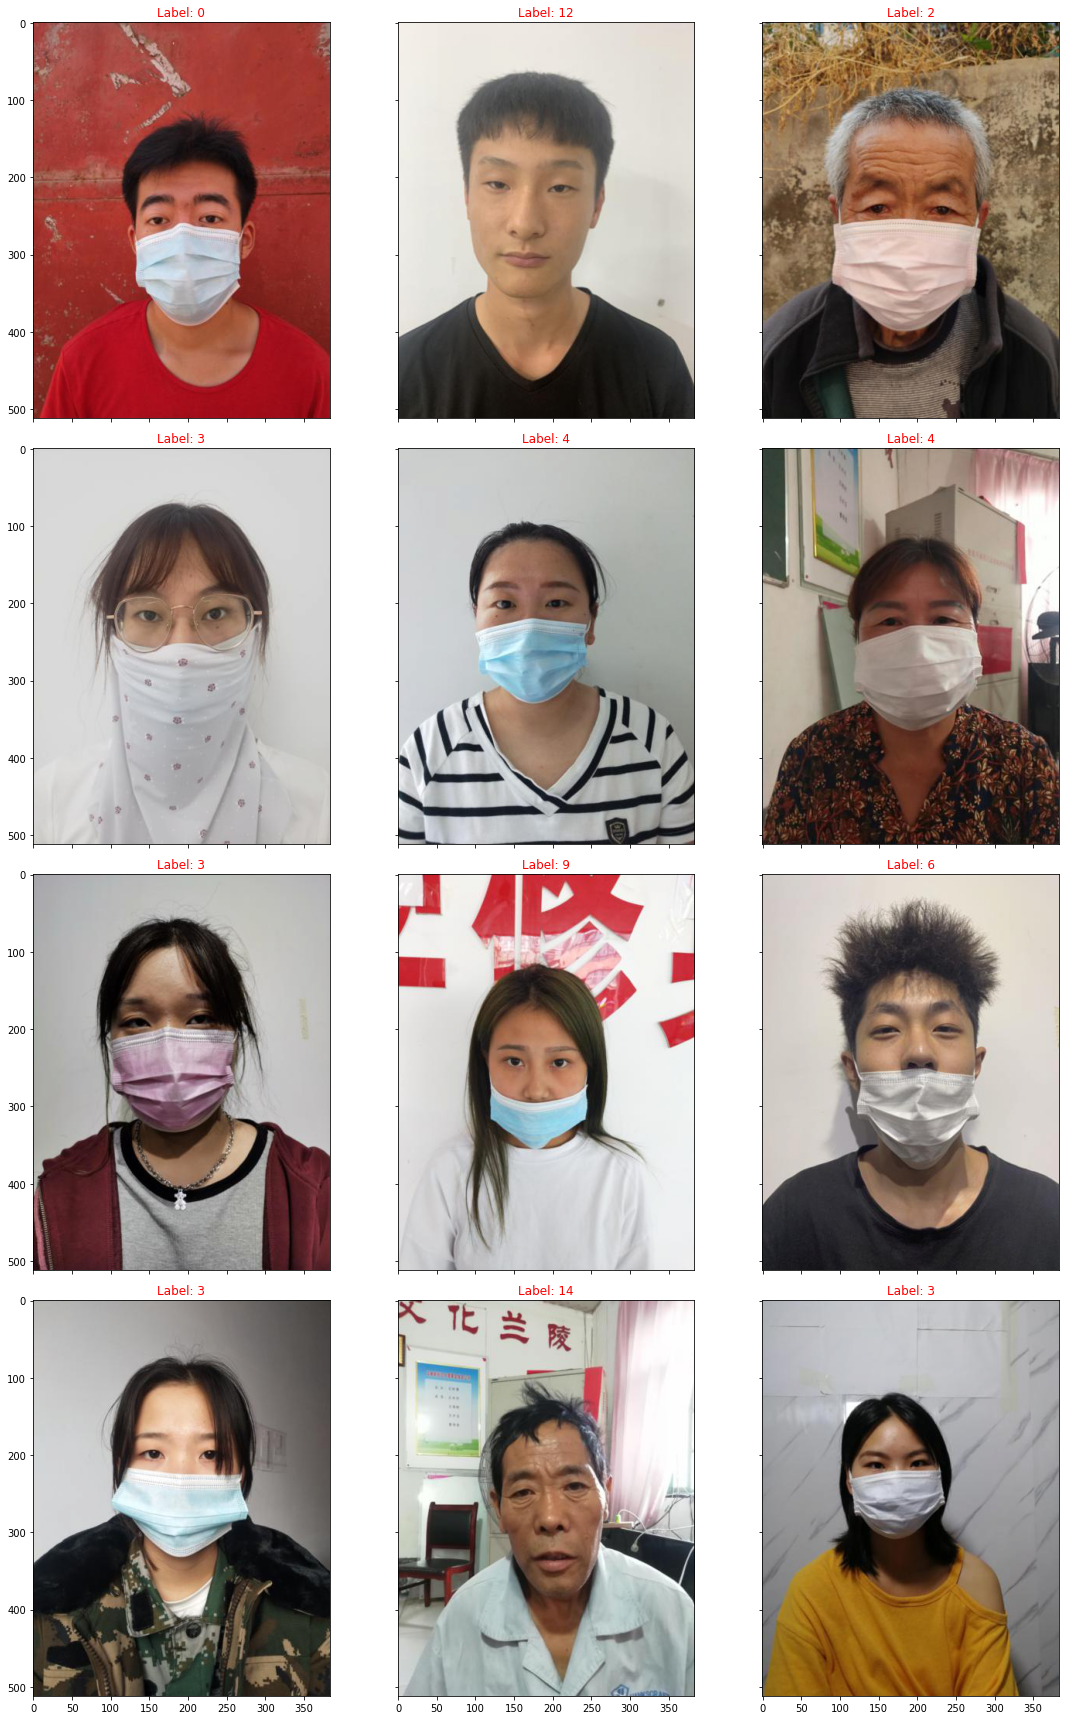

In [15]:
from torchvision import transforms

# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize 해주어야합니다.
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}', color='r')
plt.tight_layout()